In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def f(x):
  return 3*x**2 - 4*x + 5

In [4]:
f(3.0)

20.0

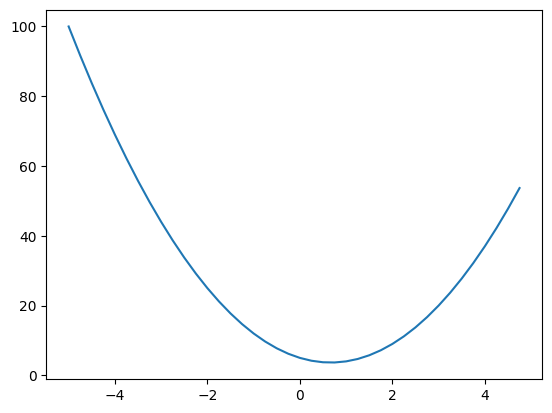

In [5]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [6]:
h = 0.001
x = 3.0
(f(x + h) - f(x))/h

14.00300000000243

In [7]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [8]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
# print('slope', (d2 - d1)/h)

d1 4.0
d2 3.999699999999999


In [89]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    # holds the derivative
    self.grad = 0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __sub__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data - other.data, (self, other), '-')
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
      self.grad += other * (self.data ** (other -1)) * out.grad

    out._backward = _backward

    return out

  def __radd__(self, other):
    return self + other

  def __rmul__(self, other):
    return self * other

  def __truediv__(self, other):
    return self * other**-1

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad

    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    topo

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()



a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b
e.label = 'e'
d = e + c
d.label = 'd'
f = Value(-2.0, label='f')
L = d * f
L.label='L'
L

Value(data=-8.0)

In [90]:
a = Value(2.0)
b = Value(4.0)

4 + a

Value(data=6.0)

In [10]:
from graphviz import Digraph

def trace(root):
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in grpah, create a rectangular ('record') node for it
    dot.node(name=uid, label="{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label=n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

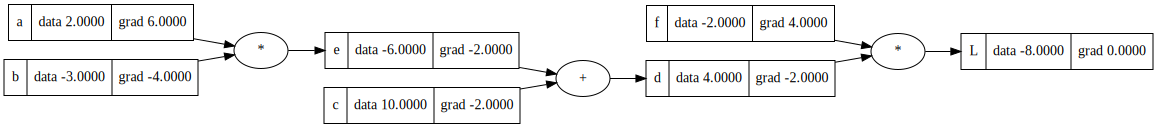

In [13]:
# this chart is visualizing the forward pass
draw_dot(L)

In [12]:
# a + node just routes the gradient because + nodes local derivatives are just 1
# with the addition of _backward func we no longer need to manually calculate derivatives
f.grad = 4.0
d.grad = -2
c.grad = -2.0
e.grad = -2.0
a.grad = 6.0
b.grad = -4

In [60]:
# nudge inputs to make L go up i.e increase in direction of gradient which at this point is 1
# gradients give us power on how to influence the final output
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-7.286496


In [48]:
# checks derivatives of variables
def lol():
  h = 0.0001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b
  e.label = 'e'
  d = e + c
  d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f
  L.label='L'
  L1 = L.data


  # to calc derivative of variable just move the + h to whichever variable you want derivative of
  # used to check the backpropagation
  a = Value(2.0 + h, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b
  e.label = 'e'
  d = e + c
  d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f
  L.label='L'
  L2 = L.data

  print((L2 - L1)/h)

lol()

6.000000000021544


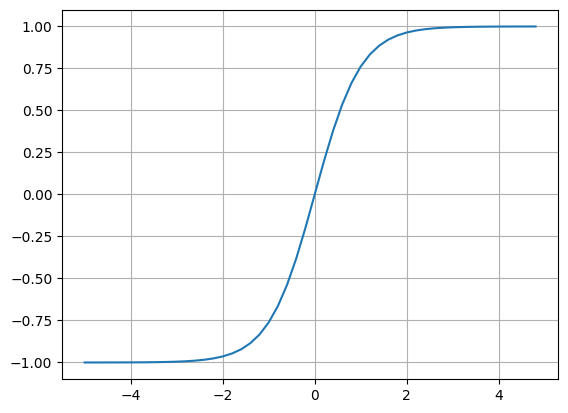

In [14]:
# tanh is an activation function in a neuron
# showing the tanh just squashes input values to the range -1 to 1
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid()

In [37]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of neuron
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
# n is now raw in the cell body without activiation function
n = x1w1x2w2 + b; n.label = 'n'

# tanh is a hyperbolic func
o = n.tanh(); o.label = 'o'

In [85]:
# with addition of _backward no longer need to calculate gradients manually
o.grad = 1.0
n.grad = 0.5
x1w1x2w2.grad = 0.5
x1w1.grad = 0.5
x2w2.grad = 0.5
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad
b.grad = 0.5

In [87]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

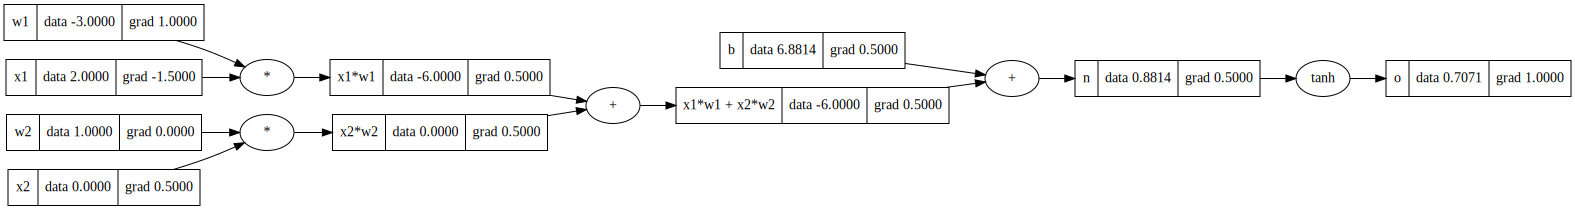

In [40]:
draw_dot(o)

In [39]:
o.backward()

In [34]:
# to automatically implement _backward we can consider the nodes in topological sort
o.grad = 1.0

topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo

for node in reversed(topo):
  node._backward()

In [33]:
o.grad = 1.0

In [24]:
o._backward()

In [25]:
n._backward()

In [26]:
b._backward()

In [27]:
x1w1x2w2._backward()

In [28]:
x2w2._backward()
x1w1._backward()

In [69]:
# o = tanh(n)
# do/dn = derivative of tanh
# do/dn = 1 - tanh(n)**2
# do/dn = 1 - o**2
1 - o.data**2

0.4999999999999999

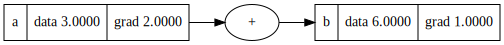

In [42]:
a = Value(3.0, label='a')
b = a + a; b.label='b'
b.backward()
draw_dot(b)

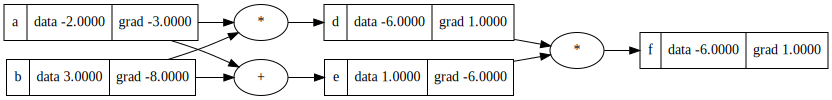

In [43]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b ; d.label='d'
e = a + b ; e.label='e'
f = d * e ; f.label='f'

f.backward()

draw_dot(f)

# Show how to implement the above in PyTorch

In [46]:
import torch

x1 = torch.Tensor([2.0]).double()     ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()     ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()    ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()     ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)


print(o.data.item())
o.backward()


print('----')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
----
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [117]:
import random

class Neuron:
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


In [118]:
x = [2.0, 3.0, -1.0]
# 3 inputs, then 4 neurons in layer 1, 4 neurons in layer 2, and 1 output layer
n = MLP(3, [4,4,1])
n(x)

Value(data=0.0039403010573652655)

In [99]:
len(n.parameters())

41

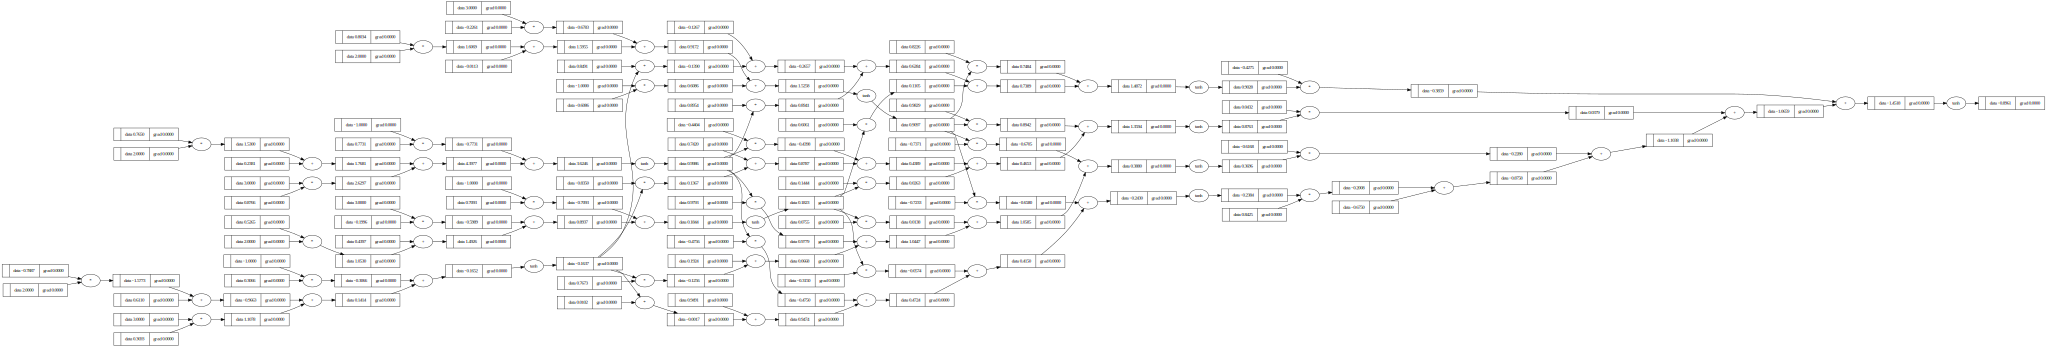

In [61]:
draw_dot(n(x))

In [119]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

ypred = [n(x) for x in xs]
ypred

[Value(data=0.0039403010573652655),
 Value(data=-0.7400166173095996),
 Value(data=-0.2496136676002623),
 Value(data=0.02444827300132929)]

In [101]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=4.698108345487484)

In [107]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=4.265363423013026)

In [102]:
loss.backward()

In [103]:
n.layers[0].neurons[0].w[0].grad

-1.2841325399523136

In [104]:
n.layers[0].neurons[0].w[0].data

0.19614296594386627

In [105]:
for p in n.parameters():
  p.data += -0.01 * p.grad

In [106]:
n.layers[0].neurons[0].w[0].data

0.2089842913433894

In [124]:
for k in range(20):

  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # backward pass
  # reset the grads so they don't accumulate at each iteration
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.05 * p.grad

  print(k, loss.data)

0 0.014414391636456862
1 0.014140240378459491
2 0.013875776575199549
3 0.013620505098891452
4 0.013373963697191625
5 0.013135720323148912
6 0.012905370720368181
7 0.012682536235437273
8 0.012466861833107462
9 0.012258014292685677
10 0.012055680566670815
11 0.011859566284897222
12 0.01166939438938999
13 0.011484903886828463
14 0.011305848706992137
15 0.011131996656855292
16 0.010963128461132076
17 0.010799036881066593
18 0.01063952590414251
19 0.010484409998155975


In [125]:
ypred

[Value(data=0.9536832237849631),
 Value(data=-0.9468967601511421),
 Value(data=-0.9499366081366678),
 Value(data=0.9451103930429878)]